# Collaboration Continuous Control - Multi-Agent Deep Deterministic Policy Gradienty (MADDPG)

---

### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment

import numpy as np
from collections import deque

import torch

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# environment configuration
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe", no_graphics=True, worker_id=1)

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of `+0.1`. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of `-0.01`. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of `8` variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

In [3]:
# environment information
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of agents in the environment
n_agents = len(env_info.agents)
print('Number of agents:', n_agents)
# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)
# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like: ', states[0])

Number of agents: 2
Number of actions: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like:  [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Agent Setup

In [4]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy
import random
from collections import namedtuple, deque
import os

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class ActorNN(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=512, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(ActorNN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class CriticNN(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=512, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(CriticNN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size        
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma        
        self.seed = random.seed(seed)
        
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state        
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        
        return self.state


    
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, device, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.DEVICE = device

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""        
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        if len(self.memory) <= self.batch_size:
            return None

        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.DEVICE)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.DEVICE)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.DEVICE)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.DEVICE)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.DEVICE)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

    
    
from model import ActorNN

class Actor:

    def __init__(self, 
        device,
        key,
        state_size, action_size, random_seed,
        memory, noise,
        lr, weight_decay,
        checkpoint_folder = './'):   

        self.DEVICE = device

        self.KEY = key

        self.state_size = state_size        
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Hyperparameters
        self.LR = lr        
        self.WEIGHT_DECAY = weight_decay

        self.CHECKPOINT_FOLDER = checkpoint_folder

        # Actor Network (w/ Target Network)
        self.local = ActorNN(state_size, action_size, random_seed).to(self.DEVICE)
        self.target = ActorNN(state_size, action_size, random_seed).to(self.DEVICE)
        self.optimizer = optim.Adam(self.local.parameters(), lr=self.LR)

        self.checkpoint_full_name = self.CHECKPOINT_FOLDER + 'checkpoint_actor_' + str(self.KEY) + '.pth'
        if os.path.isfile(self.checkpoint_full_name):
            self.local.load_state_dict(torch.load(self.checkpoint_full_name))
            self.target.load_state_dict(torch.load(self.checkpoint_full_name))

        # Replay memory        
        self.memory = memory

        # Noise process
        self.noise = noise

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(self.DEVICE)

        self.local.eval()
        with torch.no_grad():
            action = self.local(state).cpu().data.numpy()
        self.local.train()        

        if add_noise:
            action += self.noise.sample()
    
        return np.clip(action, -1, 1)

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

    def reset(self):
        self.noise.reset()
     
    def checkpoint(self):
        torch.save(self.local.state_dict(), self.checkpoint_full_name)
        


from model import CriticNN

class Critic:        

    def __init__(self, 
        device,
        state_size, action_size, random_seed,        
        gamma, TAU, lr, weight_decay,
        checkpoint_folder = './'):        

        self.DEVICE = device

        self.state_size = state_size        
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Hyperparameters
        self.GAMMA = gamma
        self.TAU = TAU
        self.LR = lr
        self.WEIGHT_DECAY = weight_decay

        self.CHECKPOINT_FOLDER = checkpoint_folder
        
        # Critic Network (w/ Target Network)
        self.local = CriticNN(state_size, action_size, random_seed).to(self.DEVICE)
        self.target = CriticNN(state_size, action_size, random_seed).to(self.DEVICE)
        self.optimizer = optim.Adam(self.local.parameters(), lr=self.LR, weight_decay=self.WEIGHT_DECAY)

        self.checkpoint_full_name = self.CHECKPOINT_FOLDER + 'checkpoint_critic.pth'
        if os.path.isfile(self.checkpoint_full_name):
            self.local.load_state_dict(torch.load(self.checkpoint_full_name))
            self.target.load_state_dict(torch.load(self.checkpoint_full_name))

    def step(self, actor, memory):
        # Learn, if enough samples are available in memory  
        experiences = memory.sample()        
        if not experiences:
            return

        self.learn(actor, experiences)

    def learn(self, actor, experiences):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
  
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = actor.target(next_states)
        Q_targets_next = self.target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (self.GAMMA * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        critic_loss.backward()
        # torch.nn.utils.clip_grad_norm(self.local.parameters(), 1)
        self.optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = actor.local(states)
        actor_loss = - self.local(states, actions_pred).mean()
        # Minimize the loss
        actor.optimizer.zero_grad()
        actor_loss.backward()
        actor.optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.local, self.target)
        self.soft_update(actor.local, actor.target)

    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        tau = self.TAU
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def checkpoint(self):          
        torch.save(self.local.state_dict(), self.checkpoint_full_name)  

### 4. Train the Agent

In [5]:
# hyperparameters
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 2e-1              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 3e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

ADD_NOISE = True
SEED = 2

CHECKPOINT_FOLDER = './'

# for the MADDPG, the memory and the noise are shared between the agents
shared_memory = ReplayBuffer(DEVICE, action_size, BUFFER_SIZE, BATCH_SIZE, SEED)
noise = OUNoise(action_size, 2)


ACTOR_0_KEY = 0
ACTOR_1_KEY = 1

# in this implementation, the critic is shared too, so there is just one critic and two actors
actor_0 = Actor(DEVICE, ACTOR_0_KEY, state_size, action_size, SEED, shared_memory, noise, LR_ACTOR, WEIGHT_DECAY, CHECKPOINT_FOLDER)
actor_1 = Actor(DEVICE, ACTOR_1_KEY, state_size, action_size, SEED, shared_memory, noise, LR_ACTOR, WEIGHT_DECAY, CHECKPOINT_FOLDER)
critic = Critic(DEVICE, state_size, action_size, SEED, GAMMA, TAU, LR_CRITIC, WEIGHT_DECAY, CHECKPOINT_FOLDER)

Episode: 	482 	Score: 	1.19 	Max Score: 	2.60 	Average Score: 	0.51
Environment solved in 482 episodes!	Average Score: 0.51


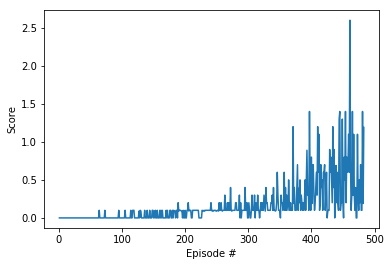

In [6]:
def maddpg_train():
    scores = []
    scores_window = deque(maxlen=100)
    n_episodes = 3000

    for episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]            # reset the environment
        states = env_info.vector_observations                        # get initial states
        actor_0.reset()                                              # reset the agent noise
        actor_1.reset()                                              # reset the agent noise
                                              
        score = np.zeros(n_agents)
        
        while True:
            action_0 = actor_0.act( states[ACTOR_0_KEY], ADD_NOISE )
            action_1 = actor_1.act( states[ACTOR_1_KEY], ADD_NOISE )
            actions = np.concatenate( (action_0, action_1) )
        
            env_info = env.step( actions  )[brain_name]              # send the action to the environment                            
            next_states = env_info.vector_observations               # get the next state        
            rewards = env_info.rewards                               # get the reward        
            dones = env_info.local_done                              # see if episode has finished        

            actor_0.step(states[ACTOR_0_KEY], action_0, rewards[ACTOR_0_KEY], next_states[ACTOR_0_KEY], dones[ACTOR_0_KEY])
            actor_1.step(states[ACTOR_1_KEY], action_1, rewards[ACTOR_1_KEY], next_states[ACTOR_1_KEY], dones[ACTOR_1_KEY])
            
            critic.step(actor_0, shared_memory)
            critic.step(actor_1, shared_memory)

            score += rewards                                         # update the score
        
            states = next_states                                     # roll over the state to next time step        
                                                        
            if np.any( dones ):                                      # exit loop if episode finished        
                break                                        

        actor_0.checkpoint()
        actor_1.checkpoint()
        critic.checkpoint()

        scores.append(np.max(score))
        scores_window.append(np.max(score))
        
        print('\rEpisode: \t{} \tScore: \t{:.2f} \tMax Score: \t{:.2f} \tAverage Score: \t{:.2f}'.format(episode, np.max(score), np.max(scores), np.mean(scores_window)), end="")  
        
        if np.mean(scores_window) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
            break    

    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()    


# train the agent
maddpg_train()

### 5. Test the Agent

In [7]:
# test the trained agents
for episode in range(3):
    env_info = env.reset(train_mode=False)[brain_name]           # reset the environment
    states = env_info.vector_observations                        # get initial states
    score = np.zeros(n_agents)
    
    while True:
        action_0 = actor_0.act(states[ACTOR_0_KEY], add_noise=False)
        action_1 = actor_1.act(states[ACTOR_1_KEY], add_noise=False)
        actions = np.concatenate((action_0, action_1))
        
        env_info = env.step( actions )[brain_name]               # send the action to the environment                            
        next_states = env_info.vector_observations               # get the next state        
        rewards = env_info.rewards                               # get the reward        
        dones = env_info.local_done                              # see if episode has finished        
        
        score += rewards

        states = next_states

        if np.any(dones):                              
            break

    print('Episode: \t{} \tScore: \t{:.2f}'.format(episode, np.max(score)))  

Episode: 	0 	Score: 	2.60
Episode: 	1 	Score: 	0.10
Episode: 	2 	Score: 	1.60


In [8]:
env.close()